# Logistic Model Trees

## LogitBoost as a feature selector
For the logistic regression model, there are no closed-form solutions for these estimates. Instead, we have to use numeric optimization algorithms that approach the maximum likelihood solution iteratively and reach it in the limit. In a recent paper that links boosting algorithms like AdaBoost to additive modeling in statistics, Friedman et al. propose the LogitBoost algorithm for fitting additive logistic regression models by maximum likelihood.  

This means we can use the *LogitBoost* algorithm to learn linear logistic regression models, by fitting a standard least-squares regression function as the $f_{mj}$ in step 2(a)ii. of the algorithm.  

If it is stopped before it converges to the maximum likelihood solution, using simple regression will result in automatic attribute selection, because the model will only include the most relevant attributes present in the data. The stopping criterion can be based on cross-validation: only perform more iterations (and include more attributes) if this actually improves predictive accuracy over unseen instances.  

We determine the optimum number of LogitBoost iterations by a five fold cross-validation: we split the data five times into training and test sets, run LogitBoost on every training set up to a maximum number of iterations (500) and log the classification error on the respective test set. Afterwards, we run LogitBoost again on all data using the number of iterations that gave the smallest error on the test set averaged over the five folds. We will refer to this implementation as **SimpleLogistic**.

## Handling nominal attributes and missing values
**Nominal attributes**  
The regression functions used in the *LogitBoost* algorithm can only be fit to numeric attributes, so we have to convert those attributes to numeric ones. We followed the standard approach for doing this: a nominal attribute with $k$ values is converted into $k$ numeric indicator attributes, where the $l$-th indicator attribute takes on value 1 whenever the original attribute takes on its $l$-th value and value 0 everywhere else.  

**Missing values**  
The regression functions that have to be fit in an iteration of LogitBoost cannot directly handle missing values, so one has to fill in the missing values for such instances. We used a simple global scheme for this: at training time, we calculate the mean (for numeric attributes) or the mode (for nominal attributes) of the values for each attribute and use these to replace missing values in the training data. When classifying unseen instances with missing values, the same mean/mode is used to fill in the missing value.


## The model **LMT**
A logistic model tree basically consists of a standard decision tree structure with logistic regression functions at the leaves, much like a model tree is a regression tree with regression functions at the leaves. As in ordinary decision trees, a test on one of the attributes is associated with every inner node. For a nominal (enumerated) attribute with k values, the node has $k$ child nodes, and instances are sorted down one of the k branches depending on their value of the attribute. For numeric attributes, the node has two child nodes and the test consists of comparing the attribute value to a threshold: an instance is sorted down the left branch if its value for that attribute is smaller than the threshold and sorted down the right branch otherwise.  

Ideally, we want our algorithm to adapt to the dataset in question: for small datasets where a simple linear model offers the best bias-variance tradeoff, the logistic model ‘tree’ should just consist of a single logistic regression model, i.e. be pruned back to the root. For other datasets, a more elaborate tree structure is adequate.  

The LogitBoost algorithm (discussed in Section 2.3) provides a natural way to do just that. Recall that it iteratively changes the linear class functions $F_j(x)$ to improve the fit to the data by adding a simple linear regression function $f_{mj}$ to $F_j$, fit to the response variable. This means changing one of the coefficients in the linear function $F_j$ or introducing a new variable/coefficient pair. After splitting a node we can continue running LogitBoost iterations, fitting the $f_{mj}$ to the response variables of the training examples at the child node only.  

Consider a tree with a single split at the root and two successor nodes. The root node $n$ has training data $D_n$ and one of its children $t$ has a subset of the training data $D_t ⊂ D_n$.The tree is constructed as follows. We start by building a logistic model $f_n$ at $n$ by running LogitBoost on $D_n$, including more and more variables in the model by adding simple regressions $f_{mj}$ to the $F^n_j$ (the linear class function for each class $j$ at node $n$). At some point, adding more variables does not increase the accuracy of the model, but splitting the instance space and refining the logistic models locally in the two subdivisions created by the split might give a better model. So we split the node n and build refined logistic models at the child nodes by proceeding with the LogitBoost algorithm on the smaller set of examples $D_t$, adding more simple regression functions to the $F^n_j$ to form the $F^t_j$. These simple linear regressions are fit to the response variables of the set of training examples $D_t$ given the (partial) logistic regression already fit at the parent node

### Main ideas
* Tree growing starts by building a logistic model at the root using the LogitBoost algorithm to iteratively fit simple linear regression functions, using five fold cross-validation to determine the appropriate number of iterations (i.e. using the SimpleLogistic algorithm described in Section 2.3).
* A split for the data at the root is constructed. Splits are either binary (for numeric attributes) or multiway (for nominal ones), the splitting criterion will be discussed in more detail below. Tree growing continues by sorting the appropriate subsets of data to the child nodes and building the logistic models at the child nodes in the following way: the LogitBoost algorithm is run on the subset associated with the child node, but starting with the committee $F_j(x)$, weights $w_{ij}$ and probability estimates $p_{ij}$ of the last iteration performed at the parent node (it is ‘resumed’ at step 2.a of Figure 3). Again, the optimum number of iterations to perform (the number of $f_{jm}$ to add to $F_j$) is determined by a five fold cross validation.
* Splitting of the child nodes continues in this fashion until some stopping criterion is met (the stopping criterion is discussed in Section 4.2.2). 
* Once the tree has been built it is pruned using CART-based pruning.

### Pseudocode
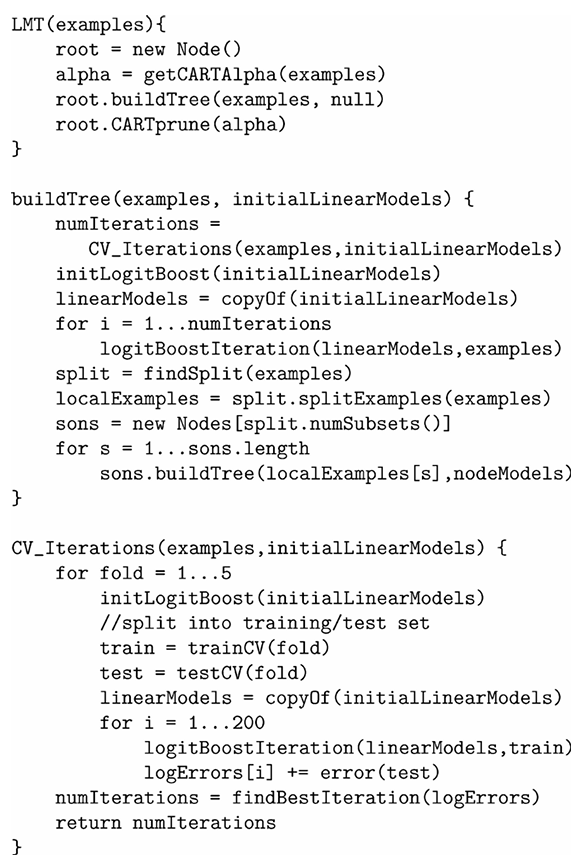

The method `LMT` constructs the tree given the training data examples. It calls `getCARTAlpha` to cross validate the ‘cost-complexity-parameter’ for the CART pruning scheme implemented in `CARTPrune`. The method `buildTree` grows the logistic model tree by recursively splitting the instance space. The argument `initialLinearModels` contains the simple linear regression functions already fit by LogitBoost at higher levels of the tree. The method `initLogitBoost` initializes the probabilities/weights for the LogitBoost algorithm as if it had already fitted the regression functions `initialLinearModels` (resuming LogitBoost at step 2.a). The method `CV_Iterations` determines the number of LogitBoost iterations to perform, and `logitBoostIteration` performs a single iteration of the LogitBoost algorithm (step 2), updating the probabilities/weights and adding a regression function to `linearModels`.


### Splitting and stopping
We implemented two different criteria to select the attribute to split on. One is the C4.5 splitting criterion that tries to improve the purity of the class variable. The other splitting criterion attempts to divide the training data according to the current values of the working responses in the LogitBoost procedure. We made splitting on the class variable (using the C4.5 splitting criterion) the default option in our algorithm.  

Tree growing stops for ine of three reasons:
* A node is not split if it contains less than 15 examples. This number is somewhat larger than for standard decision trees, however, the leaves in logistic model trees contain more complex models, which need more examples for reliable model fitting.
* A particular split is only considered if there are at least 2 subsets that contain 2 examples each. Furthermore, a split is only considered if it achieves a minimum information gain. This is a heuristic used by the C4.5 algorithm to avoid overly fragmented splits. When no such split exists, we stop growing the tree.
* A logistic model is only built at a node if it contains at least 5 examples, because we need 5 examples for the cross-validation to determine the best number of iterations for the LogitBoost algorithm. Note that this can lead to ‘partially expanded’ nodes, where for some branches no additional iterations of LogitBoost are performed and so the model at the child is identical to the model of the parent.

### Pruning the tree
For logistic model trees, sometimes a single leaf (a tree pruned back to the root) leads to the best generalization performance, which is rarely the case for ordinary decision trees.  

We employed the pruning method from the CART algorithm. The CART pruning method uses a combination of training
 error and penalty term for model complexity to make pruning decisions.

### Algorithm Explanation
We used a maximum number of 200 iterations for the logistic regression at the nodes of the tree, as opposed to the 500 iterations used in stand-alone SimpleLogistic.  


**Step by step**

1. **Preprocessing**
   * Replace missing values:
     * Numeric attributes: impute with the mean.
     * Nominal attributes: impute with the mode.  

   * Convert nominal attributes into binary indicators (one-hot encoding) so they can be used in logistic regression models.

2. **Initialize Tree Growth at the Root**
   * At the root node, train a logistic regression model using the **LogitBoost** algorithm.
     * The model is constructed **stage-wise**, by iteratively adding simple (univariate) linear regressions.
     * The optimal number of iterations is selected via **5-fold cross-validation**, using the **SimpleLogistic** approach.
     * A maximum of **200 iterations** is allowed for each model (compared to 500 in the stand-alone version).

3. **Splitting the Data** 
   At some point, adding more variables does not increase the accuracy of the model, but splitting the instance space and refining the logistic models locally in the two subdivisions created by the split might give a better model. So we split the node n and build refined logistic models at the child nodes by proceeding with the LogitBoost algorithm on the smaller set of examples $D_t$, adding more simple regression functions to the $F^n_j$ to form the $F^t_j$.

   * Attempt to split the data at the current node:
     * Use the **C4.5 information gain criterion** (default) to evaluate candidate splits.
     * For numeric and nominal attributes: test binary splits since nominal attributes are already one-hot encoded

   * Only consider a split if:
     * It creates **at least 2 subsets** with **at least 2 examples each** (particular split), and
     * It achieves a **minimum information gain** (as in C4.5) to avoid overly fragmented partitions.

4. **Stopping Criteria**
   * **Do not split** the node if:
     * It contains **fewer than 15 examples** (insufficient data for fitting complex models).
     * No split satisfies the minimum criteria mentioned above.

   * **Do not build** a logistic regression model at the node if:
     * It contains **fewer than 5 examples**, since 5-fold cross-validation cannot be reliably applied.
     * This may result in **partially expanded** nodes, where some children inherit their parent's model without modification.

5. **Growing Subtrees**
   * If a valid split is found:
     * Partition the data accordingly and create child nodes.
     * For each child node:

       * **Resume LogitBoost** from the model trained at the parent:
         * This includes continuing with the class functions $F_j(x)$, instance weights $w_{ij}$, and probability estimates $p_{ij}$ from the last parent iteration.

       * Again, determine the number of additional iterations using **5-fold cross-validation**.
       * Repeat this process recursively: build a logistic model, split if possible, and continue growing.

6. **Pruning the Tree**
   * Once the full tree is grown, apply **cost-complexity pruning** using the CART algorithm:
     * For each subtree, evaluate a **pruning criterion** that combines:
       * The classification error on the training data.
       * A penalty term proportional to the **model complexity** (e.g., number of terminal nodes).

     * Use cross-validation to determine the **optimal trade-off** between model fit and complexity.

   * This process may result in pruning the tree back to the **root** if the global logistic model generalizes best—a behavior that is rare in ordinary decision trees but common in LMT.

7. **Final Output**
   * The result is a **Logistic Model Tree**, where:
     * **Internal nodes** perform attribute-based splits (as in a decision tree).
     * **Leaf nodes** contain logistic regression models that estimate **class probabilities**.

   * The model structure is adaptive:
     * For simple problems: the tree may remain shallow or consist only of the root logistic model.
     * For complex problems: deeper trees with localized logistic regressions are created, balancing bias and variance.



### High level pseudocode
aa

## Implementation
The implementation is going to be in sections, marked as follows:
  * **Section 1** – utilities
  * **Section 2** – LogitBoost (J classes) with 5-fold early stopping
  * **Section 3** – data preprocessing (mean / mode imputation + one-hot)
  * **Section 4** – C4.5 split search (information-gain)
  * **Section 5** – recursive growth of the Logistic-Model-Tree
  * **Section 6** – prediction helpers (class & probability)
  * **Section 7** – very small cost–complexity pruning helper (optional)

In [13]:
# Libraries
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import copy

In [14]:
# ---------------------------------
# Section 1 : utilities
# ---------------------------------

# def _softmax(F):
#     """
#     Function to compute the softmax of an array F.
#     Parameters:
#     F : array-like, input array for which the softmax is to be computed

#     Returns:
#     Softmax of the input array F.
#     """
#     return np.exp(F) / np.sum(np.exp(F), axis=1, keepdims=True)

def _softmax(F, axis=1):
    """
    Numerically-stable soft-max.
    """
    F = F - np.max(F, axis=axis, keepdims=True)
    np.exp(F, out=F)
    F /= np.sum(F, axis=axis, keepdims=True)
    return F


def _entropy(y):
    """
    Function to compute the multiclass entropy in bits. E(I) = -∑p(I)*log2p(I)
    Parameters:
    y : array-like, input array of class labels

    Returns:
    Entropy of the class labels y in bits.
    """
    _, cnts = np.unique(y, return_counts=True)
    p = cnts / cnts.sum()
    return -np.sum(p * np.log2(p + 1e-12))

In [15]:
# ----------------------------------------------------------------------
# Section 2 : LogitBoost with early stopping and 5-fold cross-validation
# ----------------------------------------------------------------------
def _best_feature_lr(X, z, w):
    """
    Function to return the single feature whose weighted simple (linear) regression gives the smallest 
    weighted sum of square error w·(z − f)^2
    
    Parameters:
    X : array (n_samples, n_features)
    z : array (n_samples,) -- working response
    w : array (n_samples,) -- weights for each sample

    Returns:
    feat_idx : int -- index of the best feature
    intercept : float -- intercept of the best linear regressor
    slope : float -- slope of the best linear regressor
    fitted_values : array (n_samples,) -- predicted values from the best linear regressor
    """
    # Data initialization
    best_err = np.inf
    best_idx = None
    best_b0  = best_b1 = 0.0
    best_fit = None

    # Iterate over each feature
    for k in range(X.shape[1]):
        # Fit a linear regression model to the k-th feature
        # using the working response z and weights w
        lr = LinearRegression()
        lr.fit(X[:, k].reshape(-1, 1), z, sample_weight=w)

        # Predict the fitted values
        f_hat = lr.predict(X[:, k].reshape(-1, 1))
        # Calculate the weighted sum of squared errors
        err   = np.sum(w * (z - f_hat) ** 2)

        # Update the best feature if the current error is lower
        # than the best error found so far
        if err < best_err:
            best_err = err
            best_idx = k
            best_b0  = lr.intercept_
            best_b1  = lr.coef_[0]
            best_fit = f_hat

    return best_idx, best_b0, best_b1, best_fit

# -----------
# TRAINING 
# -----------
def _logitboost_fit(X, y, n_estimators=200, eps=1e-5, init_F=None):
    """
    Function to fit multiclass LogitBoost with a parameter to obtain weights and probabilities as an input.
    Parameters:
    X : array (n_samples, n_features)
    y : array (n_samples,) -- int labels in {0, 1, ..., J-1}
    n_estimators : int, number of boosting rounds (M)
    eps : float, lower/upper bound for p so that p∈[eps, 1-eps]
    init_F : array (n_samples, J) -- initial scores / probabilities, if None then F is initialized to zeros, is F_{ij}

    Returns:
    learners : list of length n_estimators where each element is a list of J tuples (feat_idx, b0, b1)
                where feat_idx is the index of the feature used, b0 is the intercept, and b1 is the slope of the linear regressor
    J : int, number of classes
    F : array (n_samples, J) -- final scores / probabilities after fitting
    """
    # Data initialization and conversion
    X = np.asarray(X, float)
    y = np.asarray(y,  int).ravel()
    n_samples, n_features = X.shape
    J = int(y.max()) + 1

    # — initial scores / probas —
    if init_F is None:
        # Step 1 : Start with weights w_ij = 1/N, F(x) = 0, p_ij = 1/J
        w = np.full(n_samples, 1.0 / n_samples)
        F = np.zeros((n_samples, J))
        p = np.full_like(F, 1.0/J)
    else:
        # If you have initial scores, use them as a warm-start
        F = init_F.copy()
        p = _softmax(F)

    learners = []

    # Step 2 : Iterative boosting
    for m in range(n_estimators):
        # Initialize lists for this round
        round_learners, fits = [], []

        # Step 2.a : Iterate over classes
        for j in range(J):
            # Step 2.a.i ; Compute working response and weights for class j
            # y == j is the binary response for class j (boolean mask for class j)
            w = np.clip(p[:, j] * (1.0 - p[:, j]), eps, None) # weights w_ij with numerical safety
            z = ((y == j).astype(float) - p[:, j]) / w  # z_ij

            # Step 2.a.ii : Fit the function f_mj(x) by a weighted least-squares regression of z_ij to x_i with weights w_ij.
            idx, b0, b1, f_hat = _best_feature_lr(X, z, w)

            round_learners.append((idx, b0, b1))
            fits.append(f_hat)

        # Step 2.b : Update of f_mj and F_j(x)
        fits = np.vstack(fits)  # Outputs of the weak learners, shape J × n_samples
        mean_f = fits.mean(axis=0, keepdims=True)  # mean over all classes, shape 1 × n_samples
        adj_f  = (J - 1) / J * (fits - mean_f) # adjust the scores
        F += adj_f.T # F_j(x) = F_j(x) + f_mj(x)

        # Step 2.c : Update of p_ij = softmax(F_j(x))
        p  = _softmax(F)
        p  = np.clip(p, eps, 1.0 - eps) # numerical safety

        # Store the learners for this round
        learners.append(round_learners)

    return learners, J, F # F is returned for warm-starting

# ------------------------------------------------------------
def _choose_cv_folds(y, k_desired=5):
    """
    Function to choose the number of stratified folds for cross-validation.
    Parameters:
    y : array-like, input array of class labels
    k_desired : int, desired number of folds for cross-validation

    Returns:
    k  : int, number of folds for cross-validation
    or  None  if CV should be skipped.
    
    Note : This function ensures that there are at least 2 samples per class in each fold.
    If there are not enough samples to stratify, it returns None to skip cross-validation.  
    """
    y = np.asarray(y).ravel()
    m = np.bincount(y, minlength=y.max()+1).min()
    if m < 2:                       # cannot stratify
        return None                 # -> skip CV
    return max(2, min(k_desired, m))

def logitboost_fit_cv(X, y, max_estimators=200, k=5, eps=1e-5, patience=5):
    """
    Function to fit multiclass LogitBoost with early stopping and 5-fold cross-validation in the *simple-logistic* style fit.
    Parameters:
    X : array (n_samples, n_features)
    y : array (n_samples,) -- int labels in {0, 1, ..., J-1}
    max_estimators : int, maximum number of boosting rounds (M)
    k : int, number of folds for cross-validation
    eps : float, lower/upper bound for p so that p∈[eps, 1-eps]
    patience : int, number of rounds without improvement before early stopping

    Returns:
    learners : list of length n_estimators where each element is a list of J tuples (feat_idx, b0, b1)
                where feat_idx is the index of the feature used, b0 is the intercept, and b1 is the slope of the linear regressor
    J : int, number of classes
    """
    # Data initialization and conversion
    X = np.asarray(X, float)
    y = np.asarray(y,  int).ravel()
    J = int(y.max()) + 1

    k = _choose_cv_folds(y)
    if k is None:                            # not enough data to CV
        learners, J_out, _ = _logitboost_fit(
                                X, y,
                                n_estimators=min(10, max_estimators),
                                eps=eps)
        return learners, J_out               # early exit


    # Initialize the cross-validation and variables for early stopping
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=13)
    # Initialize variables for early stopping
    # best_m is the number of estimators, best_score is the best score found so far, no_imp is the number of rounds without improvement
    best_m, best_score, no_imp = 1, np.inf, 0
    scores_path = [] # for post-hoc inspection

    # Cross-validation loop for early stopping
    # Iterate over the number of estimators
    for m in range(1, max_estimators+1):
        fold_scores = []
        # For each fold, fit the model and compute the score
        # Note: we use the simple-logistic style fit, i.e., we do not use the warm-starting
        for train_idx, val_idx in cv.split(X, y):
            # Fit the model on the training set
            learners, _, _ = _logitboost_fit(X[train_idx], y[train_idx], n_estimators=m, eps=eps)
            # Predict on the validation set
            val_pred = logitboost_predict(X[val_idx], learners, J)
            # Store the mean classification error score
            fold_scores.append((y[val_idx] != val_pred).mean())

        # Compute the average score for this fold
        avg = np.mean(fold_scores)
        # Store the score for this round
        scores_path.append(avg)

        # Check for improvement
        if avg + 1e-8 < best_score: # improvement
            # Update the best model and score
            best_m, best_score, no_imp = m, avg, 0
        else:
            # No improvement, increment the no_imp counter
            no_imp += 1
            # Check for early stopping
            if no_imp >= patience:  # early-stop
                break

    # With the best number of estimators, fit the final model
    learners, _, _ = _logitboost_fit(X, y, n_estimators=best_m, eps=eps)
    return learners, J


# -------------
# PREDICTION 
# -------------
def _accumulate_F(X, learners, J):
    """
    Function to compute additive scores  F_j(x)  for every sample.
    Parameters:
    X : array (n_samples, n_features)
    learners : list of length n_estimators
    J : int, number of classes

    Returns:
    F : array (n_samples, J) -- additive scores for each class
    """
    # Data validation and conversion
    X = np.asarray(X, float)
    F = np.zeros((X.shape[0], J))

    # Iterate over learners and accumulate the scores
    for round_learners in learners:
        # Each round_learners is a list of tuples (idx, b0, b1) for each class
        fits = []
        # For each learner, compute the fitted values
        for (idx, b0, b1) in round_learners:
            fits.append(b0 + b1 * X[:, idx])
        # Stack the fitted values and compute the mean
        fits   = np.vstack(fits)
        mean_f = fits.mean(axis=0, keepdims=True)
        # Adjust the scores to ensure they sum to zero across classes
        adj_f  = (J - 1) / J * (fits - mean_f)
        # Updtate the additive scores F_j(x) = F_j(x) + f_mj(x)
        F     += adj_f.T

    return F


def logitboost_predict_proba(X, learners, J):
    return _softmax(_accumulate_F(X, learners, J))


def logitboost_predict(X, learners, J):
    # Step 3: Output the classifier argmax_j F_j(x)
    return _accumulate_F(X, learners, J).argmax(axis=1)


In [16]:
# ----------------------------------------------------------------------
# Section 3 : Data preprocessing
# ----------------------------------------------------------------------
def preprocess_dataframe(df, numeric_strategy='mean', cat_strategy='most_frequent'):
    """
    Function to preprocess a pandas DataFrame by imputing missing values and one-hot encoding categorical variables.
    Parameters:
    df : pandas DataFrame, input DataFrame to preprocess
    numeric_strategy : str, strategy for imputing numeric columns (default: 'mean')
    cat_strategy : str, strategy for imputing categorical columns (default: 'most_frequent')

    Returns:
    X : numpy array, preprocessed feature matrix
    ohe : OneHotEncoder, fitted OneHotEncoder for categorical variables
    imp_num : SimpleImputer, fitted SimpleImputer for numeric variables
    imp_cat : SimpleImputer, fitted SimpleImputer for categorical variables
    names : list, names of the features after preprocessing
    """
    # Ensure the input is a pandas DataFrame and separate numeric and categorical columns
    df_num = df.select_dtypes(include=[np.number])
    df_cat = df.select_dtypes(exclude=[np.number])

    # ---- numeric part ------------------------------------------------------
    imp_num = SimpleImputer(strategy=numeric_strategy)
    X_num   = imp_num.fit_transform(df_num)

    # ---- categorical part --------------------------------------------------
    if df_cat.shape[1] > 0:
        imp_cat = SimpleImputer(strategy=cat_strategy)
        X_cat   = imp_cat.fit_transform(df_cat)

        enc     = OneHotEncoder(sparse=False, handle_unknown='ignore')
        X_cat_ohe = enc.fit_transform(X_cat)

        cat_names = list(enc.get_feature_names_out(df_cat.columns))
    else:
        # nothing categorical
        imp_cat   = None
        enc       = None
        X_cat_ohe = np.empty((len(df), 0))
        cat_names = []

    # ---- concatenate & return ---------------------------------------------
    X = np.hstack([X_num, X_cat_ohe]).astype(float)
    feat_names = list(df_num.columns) + cat_names
    return X, enc, imp_num, imp_cat, feat_names



In [17]:
# ----------------------------------------------------------------------
# Section 4 : Splitting using C4.5-like information gain
# ----------------------------------------------------------------------
def _info_gain_numeric(X_col, y):
    """
    Function to compute the best threshold and information gain for a numeric attribute. 
    Information gain is defined as the difference between the entropy of the parent node and the weighted average entropy of the child nodes. IG = entropy(parent) - (p_left * entropy(left) + p_right * entropy(right))
    Parameters:
    X_col : array-like, numeric attribute values for the samples
    y : array-like, class labels for the samples

    Returns:
    best_gain : float, the best information gain found
    best_thr : float, the threshold that gives the best information gain
    """
    # Ensure the input is a numpy array and sort the values
    X_col = np.asarray(X_col, float)
    sort_idx  = np.argsort(X_col)
    X_sorted  = X_col[sort_idx]
    y_sorted  = y[sort_idx]

    # Initialize variables for the best gain and threshold
    best_gain, best_thr = -np.inf, None
    # Compute the entropy of the parent node
    # parent_H = -∑p(I)*log2p(I) where p(I) is the probability of class I
    parent_H = _entropy(y)

    # candidate thresholds = mid-points where class label actually changes
    # Iterate over the sorted values to find the best threshold
    for i in range(1, len(y_sorted)):
        # Skip if the current and previous class labels are the same
        if y_sorted[i-1] == y_sorted[i]:
            continue
        # Compute the threshold as the average of the current and previous values
        thr = (X_sorted[i-1] + X_sorted[i]) / 2.0
        # Create masks for left and right splits based on the threshold
        left_mask  = X_col <= thr
        right_mask = ~left_mask
        # If either split has less than 2 samples, skip this threshold
        if left_mask.sum() < 2 or right_mask.sum() < 2:
            continue
        # Compute the entropy for the left and right splits
        H_left  = _entropy(y[left_mask])
        H_right = _entropy(y[right_mask])
        # Compute the information gain
        gain = parent_H - (left_mask.mean() * H_left + right_mask.mean() * H_right)
        # If the gain is better than the best found so far, update the best gain and threshold
        if gain > best_gain:
            best_gain, best_thr = gain, thr
    return best_gain, best_thr


def _best_split(X, y, min_info_gain=1e-6):
    """
    Function to find the best attribute and threshold for splitting the dataset based on information gain.
    Parameters:
    X : array-like, shape (n_samples, n_features), feature matrix
    y : array-like, shape (n_samples,), class labels
    min_info_gain : float, minimum information gain to consider a split (default: 1e-6)

    Returns:
    best_attr : int, index of the best attribute for splitting
    best_thr : float, threshold for the best attribute
    best_gain : float, information gain for the best split
    """
    # Initialize variables to track the best attribute, threshold, and gain
    best_attr, best_thr, best_gain = None, None, 0
    # Iterate over each feature in the dataset
    for k in range(X.shape[1]):
        # Compute the information gain for the k-th feature
        col = X[:, k]
        gain, thr = _info_gain_numeric(col, y)
        # If the gain is better than the best found so far and meets the minimum threshold, update the best values
        if gain > best_gain and gain >= min_info_gain:
            best_attr, best_thr, best_gain = k, thr, gain
    return best_attr, best_thr, best_gain

In [18]:
# ----------------------------------------------------------------------
# Section 5 : Tree growth
# ----------------------------------------------------------------------

# helper – pad / map local → global
def _pad_to_global(p_local, J_global):
    """
    Expand a local probability vector (length J_node ≤ J_global)
    to length J_global by zero-padding the *missing* classes.
    """
    p_full = np.zeros(J_global, dtype=float)
    p_full[: len(p_local)] = p_local          # assumes labels 0..k map 1-to-1
    return p_full


def _build_node(X, y, parent_model, J_global, max_iter=200, min_split_size=15, min_lr_size=5, min_info_gain=1e-6):
    """
    Function to recursively build a decision tree node for logistic model trees (LMT).
    Parameters:
    X : array-like, shape (n_samples, n_features), feature matrix
    y : array-like, shape (n_samples,), class labels
    parent_model : tuple (learners, J) or None, model from the parent node for warm-starting
    J_global : int, number of classes in the global context
    max_iter : int, maximum number of boosting rounds for logistic regression (default: 200)
    min_split_size : int, minimum number of samples required to consider splitting (default: 15)
    min_lr_size : int, minimum number of samples required to fit a logistic regression model (default: 5)
    min_info_gain : float, minimum information gain to consider a split (default: 1e-6)

    Returns:
    node : dict, a dictionary representing the tree node with the following keys:
          - 'is_leaf': bool, True if the node is a leaf
          - 'model': tuple (learners, J) or None, model for the node
          - 'split_attr': int or None, index of the attribute used for splitting
          - 'split_thr': float or None, threshold value for the split
          - 'left': dict, left child node
          - 'right': dict, right child node
    """
    n = len(y)
    # Decide whether to fit a logistic model here
    model = None
    if n >= min_lr_size:
        model = logitboost_fit_cv(X, y, max_estimators=max_iter)
    else:
        model = parent_model # inherit

    # Splitting conditions
    # If there are not enough samples to split, return a leaf node
    if n < min_split_size:
        return {'is_leaf':True,  'model':model, 'split_attr':None, 'split_thr':None}
    
    # Find the best attribute and threshold for splitting
    attr, thr, gain = _best_split(X, y, min_info_gain)

    # If no viable split is found, return a leaf node
    if attr is None:
        return {'is_leaf':True,  'model':model, 'split_attr':None,'split_thr':None}
    
    # Create masks for left and right splits based on the threshold
    left_idx  = X[:, attr] <= thr
    right_idx = ~left_idx
    # If either split has less than 2 samples, return a leaf node
    if left_idx.sum() < 2 or right_idx.sum() < 2:
        return {'is_leaf':True,  'model':model, 'split_attr':None,'split_thr':None}

    # Recursively build the left and right child nodes
    # Note: we pass the parent model for warm-starting
    left_child  = _build_node(X[left_idx],  y[left_idx], parent_model=model, J_global=J_global, max_iter=max_iter, min_split_size=min_split_size, min_lr_size=min_lr_size, min_info_gain=min_info_gain)
    right_child = _build_node(X[right_idx], y[right_idx], parent_model=model, J_global=J_global, max_iter=max_iter, min_split_size=min_split_size, min_lr_size=min_lr_size, min_info_gain=min_info_gain)
    # Return the node with the model, split attribute, threshold, and child nodes
    return {'is_leaf':False, 'model':model, 'split_attr':attr, 'split_thr':thr, 'left':left_child, 'right':right_child}


def lmt_fit(df, target, max_iter=200, min_split_size=15, min_lr_size=5, min_info_gain=1e-6):
    """
    Function to fit a logistic model tree (LMT) to a pandas DataFrame.
    Parameters:
    df : pandas DataFrame, input DataFrame containing features and target variable
    target : str, name of the target variable column in the DataFrame
    max_iter : int, maximum number of boosting rounds for logistic regression (default: 200)
    min_split_size : int, minimum number of samples required to consider splitting (default: 15)
    min_lr_size : int, minimum number of samples required to fit a logistic regression model (default: 5)
    min_info_gain : float, minimum information gain to consider a split (default: 1e-6)

    Returns:
    tree : dict, the root node of the fitted logistic model tree
    meta : dict, metadata containing the encoder, imputers, feature names, and target name
    """
    # Drop the target column from the DataFrame and preprocess the features
    X_raw  = df.drop(columns=[target])
    y      = df[target].values
    X, enc, imp_num, imp_cat, feat_names = preprocess_dataframe(X_raw)

    J_global      = int(y.max()) + 1          # assumes labels are 0..J-1
    label_set_all = np.arange(J_global)
    
    # Build the logistic model tree
    # Note: we pass None as the parent_model for the root node
    tree   = _build_node(X, y, parent_model=None, J_global=J_global, max_iter=max_iter, min_split_size=min_split_size, min_lr_size=min_lr_size, min_info_gain=min_info_gain)
    # Create metadata for the fitted model
    meta = dict(encoder=enc, imp_num=imp_num, imp_cat=imp_cat, feat_names=feat_names, target_name=target, J=J_global, labels=label_set_all)
    
    return tree, meta

In [19]:
# ----------------------------------------------------------------------
# Section 6 : Prediction
# ----------------------------------------------------------------------
def _predict_single_proba(x, node, J_global):
    """
    Function to predict the class probabilities for a single sample x using the logistic model tree node.
    Parameters:
    x : array-like, shape (n_features,), input sample for which to predict probabilities
    node : dict, the tree node containing the model and split information

    Returns:
    proba : array, predicted class probabilities for the sample x
    """
    # Traverse the tree until a leaf node is reached
    while not node['is_leaf']:
        if x[node['split_attr']] <= node['split_thr']:
            node = node['left']
        else:
            node = node['right']
    # At the leaf node, use the model to predict probabilities
    # Note: node['model'] is a tuple (learners, J)
    learners, J_local = node['model']

    p_local  = logitboost_predict_proba(x.reshape(1,-1), learners, J_local)[0]
    # Use the logitboost_predict_proba function to get the probabilities for the sample x
    return _pad_to_global(p_local, J_global)


def lmt_predict_proba(df, tree, meta):
    """
    Function to predict class probabilities for a pandas DataFrame using a fitted logistic model tree.
    Parameters:
    df : pandas DataFrame, input DataFrame containing features for prediction
    tree : dict, the fitted logistic model tree
    meta : dict, metadata containing the encoder, imputers, feature names, and target name

    Returns:
    proba : numpy array, predicted class probabilities for each sample in the DataFrame
    """
    X_raw = df.copy()
    # Impute missing values and encode categorical variables
    X_num = meta['imp_num'].transform(X_raw.select_dtypes(include=[np.number]))
    if meta['encoder'] is not None and X_raw.select_dtypes(exclude=[np.number]).shape[1] > 0:
        X_cat = meta['imp_cat'].transform(X_raw.select_dtypes(exclude=[np.number]))
        X_cat = meta['encoder'].transform(X_cat)
        X     = np.hstack([X_num, X_cat]).astype(float)
    else:
        X     = X_num.astype(float)
    
    J_global = meta['J']
    # Predict probabilities for each sample in the DataFrame
    return np.vstack([_predict_single_proba(x, tree, J_global) for x in X])


def lmt_predict(df, tree, meta):
    """
    Function to predict class labels for a pandas DataFrame using a fitted logistic model tree. 
    Parameters:
    df : pandas DataFrame, input DataFrame containing features for prediction
    tree : dict, the fitted logistic model tree
    meta : dict, metadata containing the encoder, imputers, feature names, and target name

    Returns:
    labels : numpy array, predicted class labels for each sample in the DataFrame
    """
    return lmt_predict_proba(df, tree, meta).argmax(axis=1)

In [ ]:
#PENDING
# ----------------------------------------------------------------------
# Section 7 : Cost complexity pruning based on CART-style pruning
# ----------------------------------------------------------------------


# # Bottom-up statistics per node  (R, S, L, g)
# def _node_error(node, X, y):
#     """
#     Function to compute the training mis-classification rate at a node.
#     Parameters:
#     node : dict, the tree node containing the model and split information
#     X : array-like, shape (n_samples, n_features), feature matrix
#     y : array-like, shape (n_samples,), class labels

#     Returns:
#     error_rate : float, the mis-classification rate at the node
#     """
#     # Get the predictions from the model at the node
#     preds = logitboost_predict(X, *node['model'])
#     # Compute the mis-classification rate
#     return (preds != y).mean()

# def _gather_stats(node, X, y, stats):
#     """
#     Function to gather statistics for each node in the tree. Fill stats[id(node)] = (R_t , S_t , L_t , g_t)
#     Parameters:
#     node : dict, the tree node containing the model and split information
#     X : array-like, shape (n_samples, n_features), feature matrix
#     y : array-like, shape (n_samples,), class labels
#     stats : dict, dictionary to store statistics for each node

#     Returns:
#     R : float, resubstitution error at the node
#     S : float, sum of errors of descendant leaves
#     L : int, number of descendant leaves
#     g : float, cost-complexity gain at the node (R_t – S_t)/(L_t – 1)
#     """
#     # If the node is a leaf, compute the resubstitution error
#     if node['is_leaf']:
#         R = _node_error(node, X, y)
#         stats[id(node)] = (R, R, 1, np.inf) # leaves: g=∞
#         return R, R, 1

#     # If the node is not a leaf, recursively gather stats for left and right children
#     mask = X[:, node['split_attr']] <= node['split_thr']
#     # mask is True for left child, False for right child
#     Rl, Sl, Ll = _gather_stats(node['left'],  X[mask],  y[mask],  stats)
#     Rr, Sr, Lr = _gather_stats(node['right'], X[~mask], y[~mask], stats)

#     # Combine the statistics from the left and right children
#     R = _node_error(node, X, y)
#     S = Sl + Sr
#     L = Ll + Lr
#     g = (R - S) / (L - 1) if L > 1 else np.inf
#     stats[id(node)] = (R, S, L, g)
#     return R, S, L


# # One weakest-link pruning step (Algorithm pp. 2-3)
# def _prune_once(tree, X, y):
#     """
#     Function to prune the tree once based on the weakest-link pruning method.
#     Implements:
#       • compute g(t) for every internal node,
#       • alpha* = min g(t),
#       • collapse every node with g(t)=alpha*.

#     Parameters:
#     tree : dict, the fitted logistic model tree
#     X : array-like, shape (n_samples, n_features), feature matrix
#     y : array-like, shape (n_samples,), class labels

#     Returns:
#     alpha_star : float, the minimum cost-complexity gain across all internal nodes
#     pruned_tree_copy : dict, a copy of the tree after pruning
#     """
#     pruned = copy.deepcopy(tree) # copy first

#     stats = {}
#     _gather_stats(pruned, X, y, stats)    # stats on the copy

#     # Find the minimum cost-complexity gain across all internal nodes
#     alpha_star = min(g for (_, _, L, g) in stats.values() if L > 1)

#     # Collapse nodes with g(t) = alpha_star
#     def _collapse(node):
#         """
#         Collapse the node if it has g(t) = alpha_star.
#         If the node is a leaf, it is already collapsed.
#         If the node is not a leaf, recursively collapse its children.
#         """
#         # Initialise the node statistics
#         R, S, L, g = stats[id(node)]

#         # If the node has descendant leaves and g(t) = alpha_star, collapse it
#         if L > 1 and np.isclose(g, alpha_star):
#             model_keep = node['model']   # keep old model
#             node.clear()  # remove children & keys
#             node.update({
#                 'is_leaf'   : True,
#                 'model'     : model_keep,   # restore it
#                 'split_attr': None,
#                 'split_thr' : None
#             })
#             return
#         # If the node is not a leaf, recursively collapse its children
#         if not node['is_leaf']:
#             _collapse(node['left'])
#             _collapse(node['right'])
#     # Start collapsing from the root node
#     _collapse(pruned)
#     return alpha_star, pruned


# # Full α-sequence T0 ≻ T1 ≻ … ≻ TK  (weakest-link path)
# def ccp_path(tree, X, y):
#     """
#     Function to compute the cost-complexity pruning path for a logistic model tree.
#     Parameters:
#     tree : dict, the fitted logistic model tree
#     X : array-like, shape (n_samples, n_features), feature matrix
#     y : array-like, shape (n_samples,), class labels

#     Returns:
#     trees  : list of dicts, each dict is a pruned tree at a specific alpha, [T0, T1, …, TK]
#     alphas : list of floats, the corresponding alpha values for each tree in the path, [0, α1, α2, …, αK]
#     """
#     # Start with the original tree and an initial alpha=0
#     trees  = [copy.deepcopy(tree)]
#     alphas = [0.0]
#     # While the last tree is not a leaf, prune it once and append the result
#     # to the list of trees and alphas.
#     while not trees[-1]['is_leaf']:
#         alpha, next_T = _prune_once(trees[-1], X, y)
#         trees.append(next_T)
#         alphas.append(alpha)
#     return trees, alphas


# # k-fold CV to choose α  (minimum-error or 1-SE rule)
# def cv_select_subtree(df, target, k=5, rule="1se", grow_kw=None):
#     """
#     Function to select the best subtree over the alpha sequence using k-fold cross-validation.
#     Parameters:
#     df : pandas DataFrame, input DataFrame containing features and target variable
#     target : str, name of the target variable column in the DataFrame
#     k : int, number of folds for cross-validation (default: 5)
#     rule : str, selection rule for the best subtree ('min' or '1se', default: '1se')
#     grow_kw : dict, additional keyword arguments for the tree growth function (default: None)

#     Returns:
#     best_T : dict, the best subtree selected based on the cross-validation
#     alpha_hat : float, the alpha value corresponding to the best subtree

#     """
#     # Data validation and preparation
#     grow_kw = grow_kw or {}
#     X_all = df.drop(columns=[target]).values
#     y_all = df[target].values

#     # Make folds once 
#     skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
#     folds = list(skf.split(X_all, y_all)) # materialise here

#     fold_paths = [] # (path , alphas , meta_fold)
#     max_nodes  = 0

#     # Grow large trees on each fold
#     # Note: we grow large trees on the training set of each fold
#     for tr_idx, va_idx in folds:
#         # Split the DataFrame into training and validation sets
#         tr_df = df.iloc[tr_idx]

#         # Fit a large tree on the training set
#         big_fold, meta_fold = lmt_fit(tr_df, target=target, **grow_kw)
#         # Compute the cost-complexity pruning path for the large tree
#         path, alphas = ccp_path(big_fold, tr_df.drop(columns=[target]).values, tr_df[target].values)
#         # Store the path, alphas, and metadata for this fold
#         fold_paths.append((path, alphas, meta_fold))
#         max_nodes = max(max_nodes, len(path))

#     # Validation errors 
#     # Create an error matrix to store the validation errors for each fold and each subtree
#     err_mat = np.full((k, max_nodes), np.nan)
#     # Iterate over each fold and each subtree in the fold
#     for i, (path, _, meta_fold) in enumerate(fold_paths):
#         va_idx = folds[i][1] # reuse saved indices
#         val_df = df.iloc[va_idx]

#         # For each subtree in the path, predict on the validation set and compute the error
#         for j, Tk in enumerate(path):
#             preds = lmt_predict(val_df.drop(columns=[target]),
#                                 Tk, meta_fold)
#             err_mat[i, j] = (preds != val_df[target].values).mean()
#     # Compute the mean and standard error of the errors across folds
#     mean_err = np.nanmean(err_mat, axis=0)
#     se_err   = np.nanstd(err_mat, axis=0, ddof=1) / np.sqrt(k)

#     # Select the best subtree based on the specified rule
#     k_best = int(np.nanargmin(mean_err))
#     if rule == "min":
#         k_pick = k_best
#     else:                               # 1-SE rule
#         thresh = mean_err[k_best] + se_err[k_best]
#         k_pick = max(j for j, e in enumerate(mean_err) if e <= thresh)

#     # First fold's alpha and subtree are fine—all folds share same α index
#     alpha_hat = fold_paths[0][1][k_pick]
#     best_T    = fold_paths[0][0][k_pick]
#     return best_T, alpha_hat


# # Convenience: grow-and-prune in one call
# def lmt_fit_pruned(df, target, k_cv=5, rule="1se", grow_kw=None):
#     """
#     Function to fit a logistic model tree (LMT) and prune it using cost-complexity pruning.
#     Parameters:
#     df : pandas DataFrame, input DataFrame containing features and target variable
#     target : str, name of the target variable column in the DataFrame
#     k_cv : int, number of folds for cross-validation to select the best subtree (default: 5)
#     rule : str, selection rule for the best subtree ('min' or '1se', default: '1se')
#     grow_kw : dict, additional keyword arguments for the tree growth function (default: None)

#     Returns:
#     final_tree : dict, the pruned logistic model tree
#     meta : dict, metadata containing the encoder, imputers, feature names, and target name
#     alpha_hat : float, the alpha value corresponding to the best subtree
#     """
#     grow_kw = grow_kw or {}
#     # Grow large tree on full data
#     big_tree, meta = lmt_fit(df, target=target, **grow_kw)

#     # Choose alpha_hat with k-fold CV (internal)
#     best_sub, alpha_hat = cv_select_subtree(df, target,
#                                             k=k_cv, rule=rule,
#                                             grow_kw=grow_kw)

#     # Prune the big tree built on *all* data at alpha_hat
#     # Note: we use the full data to prune the tree
#     full_path, full_alphas = ccp_path(
#         big_tree,
#         df.drop(columns=[target]).values,
#         df[target].values)

#     # Find the index of the best subtree in the full path
#     idx = max(i for i,a in enumerate(full_alphas) if a <= alpha_hat + 1e-12)
#     pruned_tree = full_path[idx]
#     return pruned_tree, meta, alpha_hat


### Examples of the implementation

#### Example of object `tree`

In [ ]:
# DO NOT RUN THIS CODE
tree = {
  'is_leaf': False,
  'model':   (root_learners, 5),
  'split_attr': 0,                 # feature 0
  'split_thr':  -1.73,
  'left': {                        # child: leaf
      'is_leaf': True,
      'model':   (left_learners, 3),   # only classes {0,1,4} present
      'split_attr': None,
      'split_thr' : None
  },
  'right': {                       # child: leaf
      'is_leaf': True,
      'model':   (right_learners, 2),  # only classes {2,3}
      'split_attr': None,
      'split_thr' : None
  }
}


meta = {
    'encoder'   : OneHotEncoder(...) or None,
    'imp_num'   : SimpleImputer(...),
    'imp_cat'   : SimpleImputer(...) or None,
    'feat_names': ['feature1', 'feature2', ...],
    'target_name': 'target',
    'J'         : 5,                 # global number of classes
    'labels'    : array([0,1,2,3,4])
}

#### Synthetic data

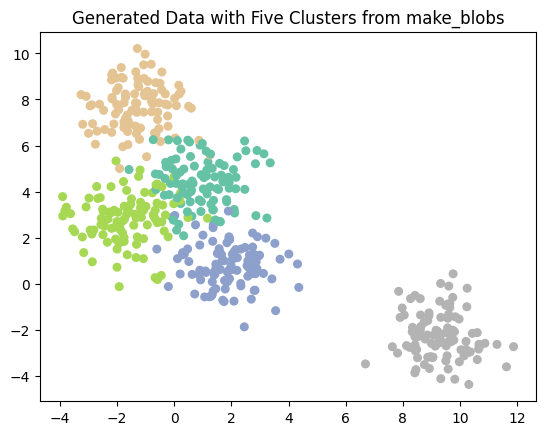

In [21]:
# Generate synthetic data
from sklearn.datasets import make_blobs
X,y = make_blobs(n_samples=500, centers=5, cluster_std=1, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Set2)
plt.title("Generated Data with Five Clusters from make_blobs")
plt.show()

In [30]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
# Put together X_tr and y_tr into a DataFrame
train_df = pd.DataFrame.merge(pd.DataFrame(X_tr, columns=['feature1', 'feature2']), pd.DataFrame(y_tr, columns=['target']), left_index=True, right_index=True)
test_df = pd.DataFrame.merge(pd.DataFrame(X_te, columns=['feature1', 'feature2']), pd.DataFrame(y_te, columns=['target']), left_index=True, right_index=True)

In [31]:
import time
# --- 1. training ------------------------------------------------------------
start_time = time.time()
tree, meta = lmt_fit(train_df, target='target')

# pruned_tree, meta, a_hat = lmt_fit_pruned(train_df, target="target", k_cv=5, rule="1se")        # you can pass rule="min"


end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")
# print(f"chosen α = {a_hat} for pruning")

Training completed in 7.61 seconds.


In [32]:
# --- 2. inference -----------------------------------------------------------
proba = lmt_predict_proba(test_df.iloc[:,:2], tree, meta)
pred  = proba.argmax(axis=1)

In [33]:
print("accuracy =", (pred == test_df['target']).mean())

accuracy = 0.92


In [35]:
# pred_pruned = lmt_predict(test_df.drop(columns=["target"]), pruned_tree, meta)
# print("accuracy", accuracy_score(test_df["target"], pred))

#### UCI datasets

In [36]:
from ucimlrepo import fetch_ucirepo

iris = fetch_ucirepo(id=53)
df = pd.concat([iris.data.features, iris.data.targets], axis=1)
df

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [37]:
# Preprocessing and exploration
dict_class = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 2
}
df['class'] = df['class'].map(dict_class)

target          = "class"                    # change for each data set
n_instances     = len(df)
pct_missing     = df.isna().mean().mean()*100

num_cols        = df.select_dtypes("number").columns
binary_cols     = [c for c in df.columns if df[c].dropna().nunique()==2 and c!=target]
cat_cols        = [c for c in df.columns if c not in num_cols and c not in binary_cols and c!=target]

n_numeric       = len(num_cols)
n_binary        = len(binary_cols)
n_nominal       = len(cat_cols)
n_classes       = df[target].nunique()

In [38]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df[target])

In [39]:
tree, meta = lmt_fit(train_df, target=target)      # trains the LMT
y_pred      = lmt_predict(test_df.drop(columns=[target]), tree, meta)

acc = accuracy_score(test_df[target], y_pred)

In [40]:
# pruned_tree, meta, a_hat = lmt_fit_pruned(train_df, target=target, k_cv=5, rule="1se")        # you can pass rule="min"
# print(f"Pruned tree chosen α = {a_hat} for pruning")

# pred_pruned = lmt_predict(test_df.drop(columns=[target]), pruned_tree, meta)
# print("accuracy with pruned tree", accuracy_score(test_df[target], pred_pruned))

In [41]:
row = dict(dataset          = "iris",
           instances        = n_instances,
           pct_missing      = pct_missing,
           num_numeric_attr = n_numeric,
           num_binary_attr  = n_binary,
           num_nominal_attr = n_nominal,
           num_classes      = n_classes,
           accuracy_mean    = acc)
summary_df = pd.DataFrame(columns=[
        "dataset", "instances", "%_missing",
        "num_numeric_attr", "num_binary_attr", "num_nominal_attr",
        "num_classes", "accuracy_mean"
])
summary_df.loc[len(summary_df)] = row 

In [42]:
summary_df 

,dataset,instances,%_missing,num_numeric_attr,num_binary_attr,num_nominal_attr,num_classes,accuracy_mean
0,iris,150,NaN,5,0,0,3,0.866667


In [43]:

# Zoo dataset
zoo = fetch_ucirepo(id=111)
df = pd.concat([zoo.data.features, zoo.data.targets], axis=1)

# Preprocessing and exploration
df['type'] = df['type'] - 1

target          = "type"               
n_instances     = len(df)
pct_missing     = df.isna().mean().mean()*100

num_cols        = df.select_dtypes("number").columns
binary_cols     = [c for c in df.columns if df[c].dropna().nunique()==2 and c!=target]
cat_cols        = [c for c in df.columns if c not in num_cols and c not in binary_cols and c!=target]

n_numeric       = len(num_cols)
n_binary        = len(binary_cols)
n_nominal       = len(cat_cols)
n_classes       = df[target].nunique()

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df[target])

# Train the LMT on the zoo dataset
tree, meta = lmt_fit(train_df, target=target)      # trains the LMT
y_pred      = lmt_predict(test_df.drop(columns=[target]), tree, meta)

# Calculate the accuracy of the predictions
acc = accuracy_score(test_df[target], y_pred)

row = dict(dataset          = "zoo",
           instances        = n_instances,
           pct_missing      = pct_missing,
           num_numeric_attr = n_numeric,
           num_binary_attr  = n_binary,
           num_nominal_attr = n_nominal,
           num_classes      = n_classes,
           accuracy_mean    = acc)
summary_df = pd.DataFrame(columns=[
        "dataset", "instances", "%_missing",
        "num_numeric_attr", "num_binary_attr", "num_nominal_attr",
        "num_classes", "accuracy_mean"
])
summary_df.loc[len(summary_df)+1] = row 
summary_df

,dataset,instances,%_missing,num_numeric_attr,num_binary_attr,num_nominal_attr,num_classes,accuracy_mean
1,zoo,101,NaN,17,15,0,7,0.903226


In [ ]:
# pruned_tree, meta, a_hat = lmt_fit_pruned(train_df, target=target, k_cv=5, rule="1se")        # you can pass rule="min"
# print(f"Pruned tree chosen α = {a_hat} for pruning")

# pred_pruned = lmt_predict(test_df.drop(columns=[target]), pruned_tree, meta)
# print("accuracy with pruned tree", accuracy_score(test_df[target], pred_pruned))